In [21]:
from pathlib import Path
import numpy as np
import transformers
import zarr
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchaudio
import lightning as L
import umap
import scipy
from lightning.pytorch import loggers
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from collections import defaultdict
import functools
import torch
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

seed = 1337

torch.set_float32_matmul_precision("medium")
L.seed_everything(seed=seed, workers=True)

Seed set to 1337


1337

In [22]:
root_path = Path("/home/john/mp/voice-finder")

train_dataset_path = root_path / "data" / "preprocessed" / "train_full_v5.zarr"
dev_dataset_path = root_path / "data" / "preprocessed" / "dev_full_v5.zarr"
test_dataset_path = root_path / "data" / "preprocessed" / "voxceleb2_v1.zarr"

In [56]:
class GuassianNoise:
    def __init__(self, rng, std: float):
        self._rng = rng
        self._std = std

    def __call__(self, features, attention_mask):

        features_noised = features + self._rng.normal(0, self._std, size=features.shape)
        return features_noised, attention_mask


class TimeMask:
    def __init__(self, rng, max_width: int, std: float = 0.01):
        self._rng = rng
        self._max_width = max_width
        self._std = std

    def __call__(self, features, attention_mask):
        start = self._rng.integers(features.shape[2], size=features.shape[0])
        width = self._rng.integers(self._max_width - 2, size=features.shape[0]) + 2
        end = np.clip(start + width, a_min=0, a_max=features.shape[2])

        for idx in range(len(features)):
            features[idx, :, start[idx] : end[idx]] = self._rng.normal(
                0, self._std, size=(features.shape[1], end[idx] - start[idx])
            )
        return features, attention_mask


class FrequencyMask:
    def __init__(self, rng, max_width: int, std: float = 0.01):
        self._rng = rng
        self._max_width = max_width
        self._std = std

    def __call__(self, features, attention_mask):
        start = self._rng.integers(features.shape[1], size=features.shape[0])
        width = self._rng.integers(self._max_width - 2, size=features.shape[0]) + 2
        end = np.clip(start + width, a_min=0, a_max=features.shape[1])

        for idx in range(len(features)):
            features[idx, start[idx] : end[idx], :] = self._rng.normal(
                0, self._std, size=(end[idx] - start[idx], features.shape[2])
            )
        return features, attention_mask


class LowFrequencyNoise:
    def __init__(self, rng, std: float, low_freq_bands: int):
        self._rng = rng
        self._low_freq_bands = low_freq_bands
        self._std = std

    def __call__(self, features, attention_mask):

        features[:, 0 : self._low_freq_bands, :] += self._rng.normal(
            0,
            self._std,
            size=(features.shape[0], self._low_freq_bands, *features.shape[2:]),
        )

        return features, attention_mask


class VoiceEmbedderDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        dataset_path: Path,
        sequence_length: int,
        samples_per_item: int,
        rng,
        xent_augmentations: list = [],
        number_xent_augmentations=0,
        triplet_augmentations: list = [],
        number_triplet_augmentations=0,
        all_samples_per_client: bool = False,
    ):
        super().__init__()
        self._rng = rng

        self._dataset_path = dataset_path
        self._dataset = zarr.open(dataset_path)

        # sequence_length * <model-stride> / 1000 = seconds
        self._sequence_length = sequence_length
        self._samples_per_item = samples_per_item

        # Precount all the samples for each client
        self._client_samples = {}
        self.prepare_client_samples()

        self._gender_map = {1: "male", 2: "female", 255: "unknown"}

        self._xent_augmentations = xent_augmentations
        self._number_xent_augmentations = number_xent_augmentations

        self._triplet_augmentations = triplet_augmentations
        self._number_triplet_augmentations = number_triplet_augmentations

        self._all_samples_per_client = all_samples_per_client

    def prepare_client_samples(self):
        for client_idx in np.unique(self._dataset["client_index"][:]):
            self._client_samples[client_idx.item()] = np.where(
                self._dataset["client_index"][:] == client_idx
            )[0]
        self._client_indices = np.array(list(self._client_samples.keys()))

    def __len__(self):
        return len(self._client_indices)

    def __getitem__(self, idx: int):
        """
        Select a client, pull samples_per_item number of audio samples from that client.
        """

        client_idx = self._client_indices[idx]

        # Randomly sample samples_per_item number of samples from this client
        if self._all_samples_per_client:
            sample_indices = self._client_samples[client_idx]
        else:
            sample_indices = np.random.choice(
                self._client_samples[client_idx],
                replace=False,
                size=self._samples_per_item,
            )

        features = self._dataset["features"][sample_indices, :]
        attention_masks = self._dataset["attention_mask"][sample_indices, :]

        for augmentation_index in range(self._number_triplet_augmentations):
            aug = self._rng.choice(self._triplet_augmentations)

            features, _ = aug(features, attention_masks)

        client_idx = np.resize(client_idx, len(sample_indices))

        client_id = [
            x.decode().strip() for x in self._dataset["client_id"][sample_indices]
        ]

        features_augmented = features.copy()

        for augmentation_index in range(self._number_xent_augmentations):
            aug = self._rng.choice(self._xent_augmentations)

            features_augmented, _ = aug(features_augmented, attention_masks)

        path = [x.decode().strip() for x in self._dataset["path"][sample_indices]]

        if "gender" in self._dataset:
            gender = [
                self._gender_map[x] for x in self._dataset["gender"][sample_indices]
            ]
        else:
            gender = ["unknown"] * len(client_idx)

        sample = {
            "client_index": client_idx,
            "sample_index": sample_indices,
            "features": features,
            "attention_mask": attention_masks,
            "features_augmented": features_augmented,
            "client_id": client_id,
            "path": path,
            "gender": gender,
        }

        sample = {
            k: torch.from_numpy(v) if isinstance(v, np.ndarray) else v
            for k, v in sample.items()
        }

        return sample

In [ ]:
sequence_length = 1000
samples_per_item = 4
batch_size = 32

general_noise_std = 0.03

time_mask_max_width = 200

freq_mask_max_width = 10

low_freq_bands = 10
low_freq_noise_std = 0.06
# low_freq_noise_std = 10.0

rng = np.random.default_rng(seed=seed)


guassian_noise = GuassianNoise(rng, general_noise_std)
time_mask = TimeMask(rng, max_width=time_mask_max_width)
freq_mask = FrequencyMask(rng, max_width=freq_mask_max_width)
low_freq_noise = LowFrequencyNoise(
    rng, low_freq_noise_std, low_freq_bands=low_freq_bands
)

xent_augmentations = [guassian_noise]


general_noised_triplet_std = 0.01
low_freq_noise_triplet_std = 0.03

guassian_noise_triplet = GuassianNoise(rng, general_noised_triplet_std)
time_mask_triplet = TimeMask(rng, max_width=time_mask_max_width)
freq_mask_triplet = FrequencyMask(rng, max_width=freq_mask_max_width)
low_freq_noise_triplet = LowFrequencyNoise(
    rng, low_freq_noise_triplet_std, low_freq_bands=low_freq_bands
)


triplet_augmentations = [
    guassian_noise_triplet,
    time_mask_triplet,
    freq_mask_triplet,
    low_freq_noise_triplet,
]


### Important Parameters

gendered = False
number_xent_augmentations = 1
number_triplet_augmentations = 0
self_supervised_loss_weight = 0.025
lr = 1e-5


def batch_group(group):
    batched = {}

    for key in group[0].keys():

        if isinstance(group[0][key], torch.Tensor):
            batched[key] = torch.concatenate([x[key] for x in group], axis=0).float()
        elif isinstance(group[0][key], list):
            batched[key] = [item for sublist in group for item in sublist[key]]
        else:
            batched[key] = [x[key] for x in group]

    return batched


def collate_fn_gendered(batch, gendered: bool):

    groups = defaultdict(list)

    for sample in batch:
        gender = sample.get("gender", "unknown")[0]

        if gendered:
            groups[gender].append(sample)
        else:
            groups["all_genders"].append(sample)

    batch = {key: batch_group(value) for key, value in groups.items()}

    return batch


collate_fn = functools.partial(collate_fn_gendered, gendered=gendered)


train_dataset = VoiceEmbedderDataset(
    train_dataset_path,
    sequence_length=sequence_length,
    rng=rng,
    samples_per_item=samples_per_item,
    xent_augmentations=xent_augmentations,
    number_xent_augmentations=number_xent_augmentations,
    triplet_augmentations=triplet_augmentations,
    number_triplet_augmentations=number_triplet_augmentations,
)

dev_dataset = VoiceEmbedderDataset(
    dev_dataset_path,
    sequence_length=sequence_length,
    rng=rng,
    samples_per_item=2,
    xent_augmentations=xent_augmentations,
    number_xent_augmentations=number_xent_augmentations,
    all_samples_per_client=True,
)

test_dataset = VoiceEmbedderDataset(
    test_dataset_path,
    sequence_length=sequence_length,
    rng=rng,
    samples_per_item=2,
    all_samples_per_client=True,
)


train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=4,
    pin_memory=True,
    shuffle=True,
    prefetch_factor=2,
    persistent_workers=True,
    collate_fn=collate_fn,
)

dev_dataloader = torch.utils.data.DataLoader(
    dev_dataset,
    batch_size=batch_size,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
    prefetch_factor=2,
    persistent_workers=True,
    collate_fn=collate_fn,
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
    prefetch_factor=2,
    persistent_workers=True,
    collate_fn=collate_fn,
)

In [42]:
batch = next(iter(test_dataloader))

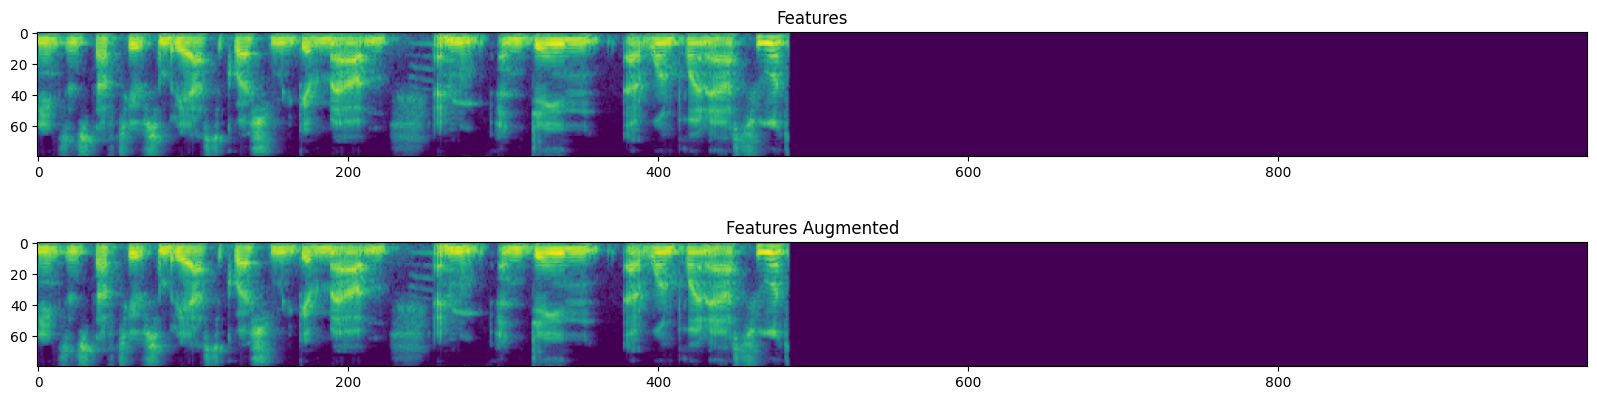

In [43]:
def plot_sample(batch, sample_index):
    features = batch["features"][sample_index, :].cpu().numpy()
    features_augmented = batch["features_augmented"][sample_index, :].cpu().numpy()

    fig, axes = plt.subplots(2, 1, figsize=(20, 5))
    axes[0].title.set_text("Features")
    axes[0].imshow(features)
    axes[1].title.set_text("Features Augmented")
    axes[1].imshow(features_augmented)
    return fig


key = list(batch.keys())[0]
f = plot_sample(batch[key], 2)

In [45]:
batch["all_genders"]["features"].shape

torch.Size([96, 80, 1000])

In [27]:
class NTXEntLoss(torch.nn.Module):
    def __init__(self, temperature: float = 0.1):
        super().__init__()
        self._temperature = temperature

    def forward(self, z1, z2):

        embs = torch.cat([z1, z2], dim=0)

        # cosine similarity since the are normalized
        sim = torch.matmul(embs, embs.T) / self._temperature

        # Mask the similarity matrix so that it excludes the self
        N = z1.size(0)
        mask = torch.eye(2 * N, device=z1.device).bool()
        sim = sim.masked_fill(mask, -float("inf"))

        # Create targets: The same index should map to itself in both tensors
        targets = torch.arange(N, device=z1.device)
        target_indices = torch.cat(
            [targets + N, targets], dim=0
        )  # size 2N, where the first half has the index of the second half and vice-versa

        loss = torch.nn.functional.cross_entropy(sim, target_indices)
        return loss


class HardMiningTripletLoss(torch.nn.Module):
    def __init__(self, margin: float = 0.2):
        super().__init__()

        self._margin = margin

    def forward(self, embeddings, labels):

        # Normalize first
        # embeddings = torch.nn.functional.normalize(embeddings, dim=1)

        # Euclidean distance between all embeddings
        distances = torch.cdist(embeddings, embeddings)

        # Online hard triplet sampling:
        # Use each sample as an anchor. For each anchor select a positive and a negative
        # The positive is selected as the sample, from the same speaker, that has the largest embedding distance to the anchor.
        # The negative is selected as the sample, from some other speaker, that has the smallest embedding distance to the anchor.
        # I.e, we try to make the task as difficult as possible for the model to learn.

        same_speaker = labels.unsqueeze(0) == labels.unsqueeze(0).T

        same_speaker_max_distance = (
            distances.masked_fill(~same_speaker, -float("inf")).max(dim=1).values
        )

        different_speaker_min_distance = (
            distances.masked_fill(same_speaker, float("inf")).min(dim=1).values
        )

        loss = torch.nn.functional.relu(
            same_speaker_max_distance - different_speaker_min_distance + self._margin
        )

        return loss.mean()


def get_model(model_name, sequence_length):

    model_state_dict = transformers.WhisperModel.from_pretrained(
        model_name
    ).state_dict()

    # Shorten embedding length to desired sequence_length
    model_state_dict["encoder.embed_positions.weight"] = model_state_dict[
        "encoder.embed_positions.weight"
    ][0 : sequence_length // 2, :]

    model_config = transformers.WhisperConfig.from_pretrained(
        model_name, max_source_positions=sequence_length // 2
    )

    model = transformers.WhisperModel(model_config)

    model.load_state_dict(model_state_dict)

    return model.encoder


class VoiceEmbedderModule(L.LightningModule):
    def __init__(
        self, sequence_length: int, lr: float, self_supervised_loss_weight: float
    ):
        super().__init__()

        self.model = get_model("openai/whisper-base", sequence_length=sequence_length)

        self.projector_head = torch.nn.Sequential(
            torch.nn.Linear(512, 512), torch.nn.ReLU(), torch.nn.Linear(512, 256)
        )

        self._lr = lr

        self._self_supervised_loss_weight = self_supervised_loss_weight
        self.nt_xent = NTXEntLoss(temperature=0.5)
        self.triplet_loss = HardMiningTripletLoss(margin=1.0)

        self.save_hyperparameters()

    def forward(self, **inputs):

        encoder_out = self.model(**inputs)

        hidden_state = encoder_out.last_hidden_state.mean(dim=1)

        embedding = self.projector_head(hidden_state)

        embedding = torch.nn.functional.normalize(embedding, p=2, dim=1)

        return embedding

    def calculate_metrics(self, batch, prefix: str, embeddings, batch_name):
        """Should probably switch to a propert torchmetrics implementation"""
        N = batch["client_index"].shape[0]
        same_speaker = (
            batch["client_index"].unsqueeze(0) == batch["client_index"].unsqueeze(0).T
        )

        l2_distances = torch.cdist(embeddings, embeddings, p=2)
        same_speaker_l2_distance = l2_distances[
            same_speaker & (~torch.eye(N, device=self.device).bool())
        ].mean()

        different_speaker_l2_distance = l2_distances[~same_speaker].mean()
        l2_distance = l2_distances[~(torch.eye(N, device=self.device).bool())].mean()

        embedding_norm = embeddings.norm(dim=1, p=2).mean()

        metrics = {
            f"{prefix}/{batch_name}_l2_distance": l2_distance,
            f"{prefix}/{batch_name}_l2_distance_same_speaker": same_speaker_l2_distance,
            f"{prefix}/{batch_name}_l2_distance_different_speaker": different_speaker_l2_distance,
            f"{prefix}/{batch_name}_embedding_norm": embedding_norm,
        }
        return metrics

    def process_batch(self, batch, batch_name, prefix):

        embeddings = self(
            input_features=batch["features"], attention_mask=batch["attention_mask"]
        )

        embeddings_augmented = self(
            input_features=batch["features_augmented"],
            attention_mask=batch["attention_mask"],
        )

        loss_nt_xent_noised = self.nt_xent(embeddings, embeddings_augmented)

        loss_triplet = self.triplet_loss(embeddings, batch["client_index"])

        loss = self._self_supervised_loss_weight * loss_nt_xent_noised + loss_triplet

        additional_metrics = self.calculate_metrics(
            batch, prefix, embeddings, batch_name
        )

        self.log(f"{prefix}/{batch_name}_loss", loss, on_epoch=True)
        self.log(
            f"{prefix}/{batch_name}_loss_nt_xent_noised",
            loss_nt_xent_noised,
            on_epoch=True,
        )
        self.log(f"{prefix}/{batch_name}_loss_triplet", loss_triplet, on_epoch=True)
        self.log_dict(additional_metrics, on_epoch=True)
        self.log(
            f"{prefix}/{batch_name}_size", batch["features"].shape[0], on_step=True
        )

        return loss

    def training_step(self, batchs, batch_idx):

        losses = {}
        for batch_name, batch in batchs.items():
            losses[batch_name] = self.process_batch(batch, batch_name, "train")

        loss = sum(losses.values()) / len(losses)

        self.log("train/loss", loss, on_epoch=True)

        return loss

    def validation_step(self, batches, batch_idx):
        losses = {}
        for batch_name, batch in batches.items():
            losses[batch_name] = self.process_batch(batch, batch_name, "validation")

        loss = sum(losses.values()) / len(losses)

        self.log("validation/loss", loss, on_epoch=True)

        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self._lr)


module = VoiceEmbedderModule(
    lr=lr,
    sequence_length=sequence_length,
    self_supervised_loss_weight=self_supervised_loss_weight,
).train()

In [8]:
accumulate_grad_batches = 4
check_val_every_n_epoch = 20
max_steps = 5000

logger = loggers.TensorBoardLogger("voice-finder-experiment")

checkpoint_callback = ModelCheckpoint(
    monitor="validation/loss",
    mode="min",
    save_on_train_epoch_end=False,
)

early_stopping = EarlyStopping(patience=30, monitor="validation/loss")

trainer = L.Trainer(
    max_steps=max_steps,
    log_every_n_steps=10,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    logger=logger,
    callbacks=[checkpoint_callback, early_stopping],
    accumulate_grad_batches=accumulate_grad_batches,
    precision="16-mixed",
    check_val_every_n_epoch=check_val_every_n_epoch,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [9]:
trainer.fit(module, train_dataloaders=train_dataloader, val_dataloaders=dev_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | model          | WhisperEncoder        | 20.1 M | train
1 | projector_head | Sequential            | 393 K  | train
2 | nt_xent        | NTXEntLoss            | 0      | train
3 | triplet_loss   | HardMiningTripletLoss | 0      | train
-----------------------------------------------------------------
20.2 M    Trainable params
256 K     Non-trainable params
20.5 M    Total params
81.890    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=5000` reached.


In [120]:
run_1_checkpoint_path = "voice-finder-experiment/lightning_logs/version_72/checkpoints/epoch=199-step=2000.ckpt"
run_2_checkpoint_path = "voice-finder-experiment/lightning_logs/version_73/checkpoints/epoch=199-step=2000.ckpt"
run_3_checkpoint_path = "voice-finder-experiment/lightning_logs/version_74/checkpoints/epoch=279-step=2800.ckpt"
run_4_checkpoint_path = "voice-finder-experiment/lightning_logs/version_76/checkpoints/epoch=299-step=3000.ckpt"
run_5_checkpoint_path = "voice-finder-experiment/lightning_logs/version_77/checkpoints/epoch=259-step=2600.ckpt"
run_6_checkpoint_path = "voice-finder-experiment/lightning_logs/version_78/checkpoints/epoch=299-step=3000.ckpt"
run_7_checkpoint_path = "voice-finder-experiment/lightning_logs/version_79/checkpoints/epoch=279-step=2800.ckpt"
run_8_checkpoint_path = "voice-finder-experiment/lightning_logs/version_80/checkpoints/epoch=279-step=2800.ckpt"
run_9_checkpoint_path = "voice-finder-experiment/lightning_logs/version_81/checkpoints/epoch=239-step=2400.ckpt"

module = VoiceEmbedderModule.load_from_checkpoint(run_8_checkpoint_path)
module = module.cuda().eval()

In [123]:
all_embeddings = []
client_indices = []
client_ids = []
genders = []
paths = []

dataloader = dev_dataloader

for batches in tqdm(dataloader, total=len(dataloader)):
    with torch.no_grad():
        for batch_name, batch in batches.items():
            embeddings = module(
                attention_mask=batch["attention_mask"].cuda(),
                input_features=batch["features"].cuda(),
            )
            all_embeddings.append(embeddings)
            client_indices.append(batch["client_index"].cuda())
            client_ids.extend(batch["client_id"])
            paths.extend(batch["path"])
            if "gender" in batch:
                genders.extend(batch["gender"])

embs = torch.concatenate(all_embeddings)
indices = torch.concatenate(client_indices)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:12<00:00,  5.16it/s]


In [124]:
# dists = torch.nn.functional.pairwise_distance(embs, embs, p=2)
dists = torch.cdist(embs, embs)
same_client = indices.unsqueeze(0) == indices.unsqueeze(0).T
avg_same_dist = dists[same_client & ~torch.eye(dists.shape[0]).bool().cuda()].mean()
avg_different_dist = dists[
    ~same_client & ~torch.eye(dists.shape[0]).bool().cuda()
].mean()

print(f"Average same distance:\t{avg_same_dist.item()}")
print(f"Average different distance:\t{avg_different_dist.item()}")

# Topk retrieval

k = 5
sim = -dists.clone()

sim[torch.eye(sim.shape[0]).bool().cuda()] = -float("inf")

topk = torch.topk(sim, k=k, dim=1)
topk_indices = topk.indices
matches = (indices[topk_indices] == indices.unsqueeze(1)).any(dim=1)
print(f"Average top-{k} match rate:\t{matches.float().mean()}")

Average same distance:	0.5543108582496643
Average different distance:	1.3676241636276245
Average top-5 match rate:	0.9768739938735962


In [125]:
embs_np = embs.cpu().numpy()

reducer = umap.UMAP(n_components=2, random_state=42)
trained_reducer = reducer.fit(embs_np)
embs_2d = trained_reducer.transform(embs_np)

/home/john/mp/voice-finder/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/john/mp/voice-finder/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(embs_2d)

In [17]:
mapping = {"male": 1, "female": 2, "unknown": 3, "m": 1, "f": 2}

In [18]:
valid = np.array([mapping[x] for x in genders]) != 3

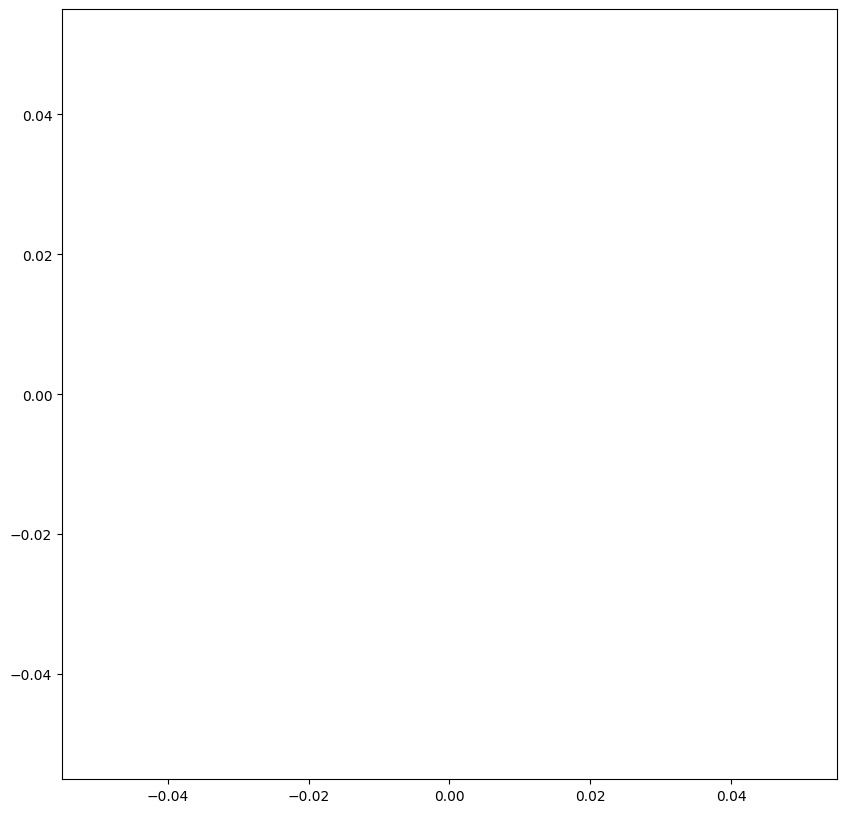

In [19]:
plt.figure(figsize=(10, 10))
plt.scatter(
    embs_2d[valid, 0],
    embs_2d[valid, 1],
    s=10,
    alpha=0.7,
    c=[mapping[x] for x in genders if x != "unknown"],
)

ValueError: 'c' argument has 8504 elements, which is inconsistent with 'x' and 'y' with size 0.

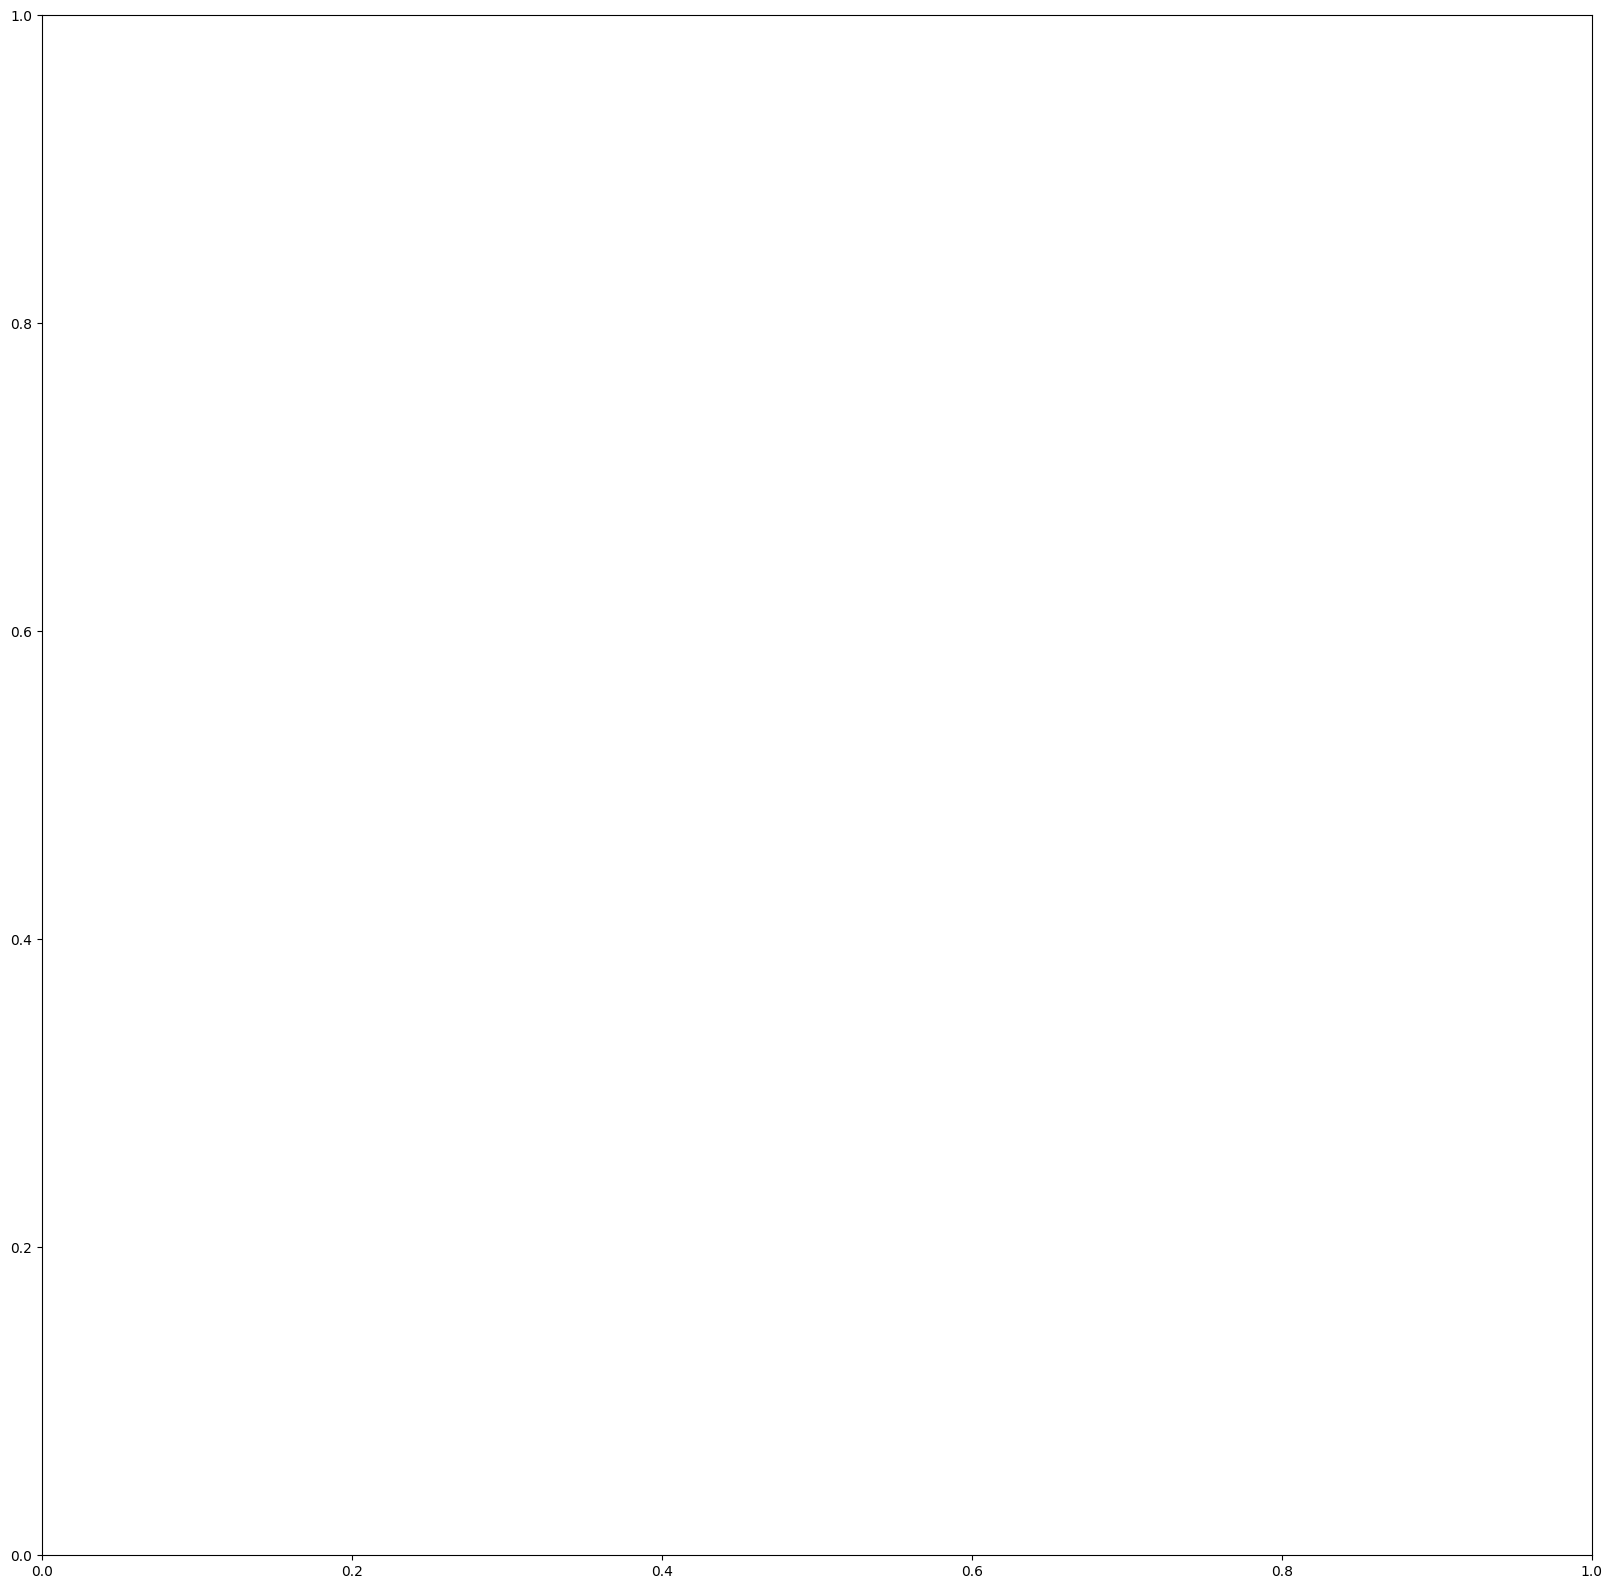

In [20]:
client_index = 4
color_mapping = (np.array(client_ids) == client_ids[client_index]).astype(np.uint8)

plt.figure(figsize=(20, 20))
plt.scatter(embs_2d[valid, 0], embs_2d[valid, 1], s=15, alpha=0.7, c=color_mapping)

In [ ]:
valid = np.array([x in ("m", "f") for x in genders])

In [ ]:
df = pd.read_csv(root_path / "data" / "vox2_meta.csv", delimiter="\t")
df["VoxCeleb2 ID"] = df["VoxCeleb2 ID "].apply(lambda x: x.strip())
df["Gender"] = df["Gender "].apply(lambda x: x.strip())
genders = (
    df[df["VoxCeleb2 ID"].isin(client_ids)]
    .set_index("VoxCeleb2 ID")
    .loc[client_ids]
    .reset_index()["Gender"]
    .to_list()
)

In [ ]:
embs_2d.shape

(4180, 2)

In [ ]:
valid.shapepy

(8504,)

In [ ]:
df[df["VoxCeleb2 ID"].isin(cluster_1)].groupby("Gender ").count().reset_index()

,Gender,Name,VoxCeleb2 ID,VGGFace2 ID,Set,VoxCeleb2 ID
0,f,1694,1694,1694,1694,1694
1,m,74,74,74,74,74


In [ ]:
df["VoxCeleb2 ID"] = df["VoxCeleb2 ID "].apply(lambda x: x.strip())

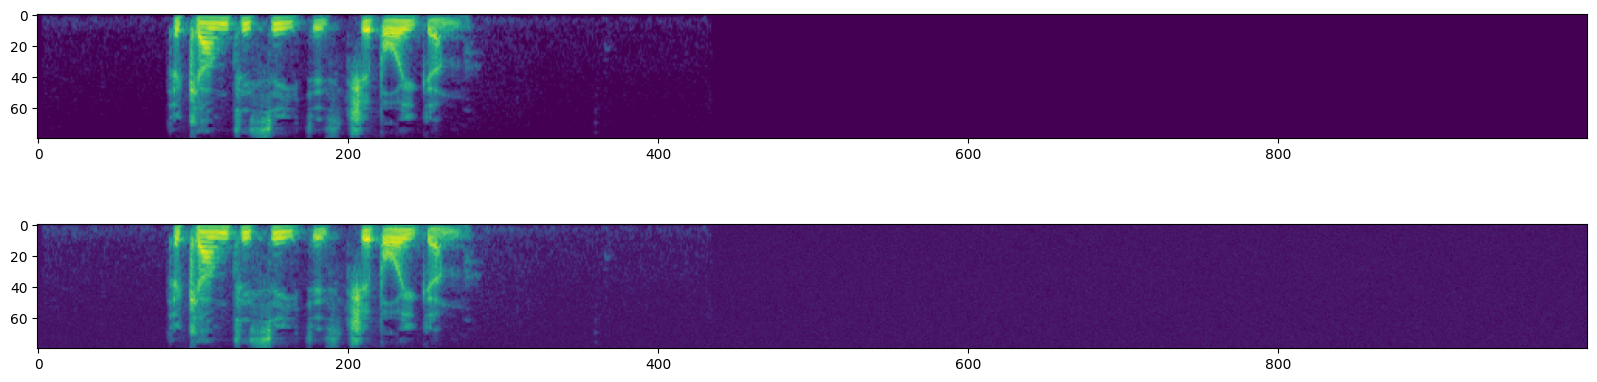

In [ ]:
dataset_sample_index = 0
audio_sample_index = 0

sample = train_dataset[dataset_sample_index]

features = sample["features"][audio_sample_index, :].numpy()

features_noised = sample["features"][audio_sample_index, :].numpy() + s.normal(
    0, 0.03, size=features.shape
)

print(f"")

fig, ax = plt.subplots(2, 1, figsize=(20, 5))
ax[0].imshow(features)
ax[1].imshow(features_noised)

In [ ]:
recordings_path = root_path / "data" / "recordings" / "john"

feature_extractor = transformers.WhisperFeatureExtractor()
all_recordings_path = list(recordings_path.iterdir())
sequence_length = 1000

features = []
attention_mask = []

for path in all_recordings_path:
    audio, sr = torchaudio.load(path)

    audio_16k = torchaudio.functional.resample(
        audio, orig_freq=sr, new_freq=16000
    ).mean(dim=0, keepdim=True)

    output = feature_extractor(
        audio_16k.squeeze(0),
        sampling_rate=16000,
        return_tensors="pt",
        return_attention_mask=True,
    )

    features.append(output["input_features"][:, :, :sequence_length])
    attention_mask.append(output["attention_mask"][:, :sequence_length])

features = torch.cat(features)
attention_mask = torch.cat(attention_mask)

rec_embeddings = module(
    input_features=features.cuda(), attention_mask=attention_mask.cuda()
)

print(f"Number of recorded embeddings:\t{rec_embeddings.shape[0]}")

cat_embs = torch.cat([rec_embeddings, embs])
dists = torch.cdist(cat_embs, cat_embs, p=2)

Number of recorded embeddings:	4


In [ ]:
dists[0:7, 0:7]

tensor([[0.0100, 0.4606, 0.6104, 0.6613, 1.5570, 1.5143, 1.1802],
        [0.4606, 0.0000, 0.7413, 0.5265, 1.6058, 1.5684, 1.1059],
        [0.6104, 0.7413, 0.0078, 0.7560, 1.5366, 1.5731, 1.2211],
        [0.6613, 0.5265, 0.7560, 0.0000, 1.5861, 1.5645, 1.1612],
        [1.5570, 1.6058, 1.5366, 1.5861, 0.0148, 0.7042, 1.4699],
        [1.5143, 1.5684, 1.5731, 1.5645, 0.7042, 0.0000, 1.4689],
        [1.1802, 1.1059, 1.2211, 1.1612, 1.4699, 1.4689, 0.0000]],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [ ]:
dists[2, 4:].min(dim=0)

torch.return_types.min(
values=tensor(0.9620, device='cuda:0', grad_fn=<MinBackward0>),
indices=tensor(1737, device='cuda:0'))

In [ ]:
batch["features"].std()

tensor(0.5503)

In [ ]:
0.55 * 0.05

0.027500000000000004